# Human Protein Atlas Image Classification

## External Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.colors as col
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from importlib import reload
from IPython.core.display import display, HTML

import seaborn as sns
from PIL import Image

import tensorflow as tf

from keras.models import Sequential, Model
from keras.layers import Conv2D, ReLU, Dense, Dropout, Input, Concatenate
from keras.layers import Activation, Flatten, MaxPooling2D, BatchNormalization
from keras import backend as K
from keras.optimizers import Adam, SGD

from IPython.display import display
import subprocess

Using TensorFlow backend.


## Local Imports

In [2]:
import protein_atlas as pa
from protein_atlas.install import PATH

## Import Data

In [3]:
reload(pa)
test  = pa.Test()
train = pa.Train()

## Output Formatting

In [4]:
# Notebook Settings
%matplotlib inline

display(HTML("<style>.container { width:100% !important; }</style>"))

# Numpy Settings
np.set_printoptions(precision = 3, linewidth = 1e5, threshold = 1e5)

# Pandas Settings
pd.set_option("display.max_colwidth", 500)
pd.set_option("display.max_columns",50)
pd.set_option("display.float_format","{:.2f}".format)



# Plot Settings
plt.rc('axes', labelsize=11)
plt.rc('xtick', labelsize=8)
plt.rc('ytick', labelsize=8)
plt.rc('savefig', pad_inches = 0)
plt.rc('xticklabel')
sns.set_palette("husl",n_colors = 4)

In [124]:
cmap = sns.choose_cubehelix_palette(gamma = 1.5,as_cmap = True)

TypeError: choose_cubehelix_palette() got an unexpected keyword argument 'gamma'

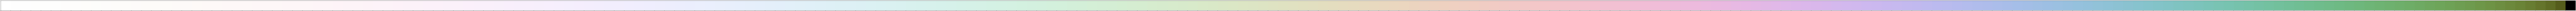

In [166]:
def make_cmap(as_cmap = False):
    return sns.cubehelix_palette(
        n_colors = 256,
        start = 1.5, 
        rot = 2.0,
        gamma = .2,
        dark = 0,
        light = 1,
        hue = 1, 
        as_cmap = as_cmap
    )
sns.palplot(make_cmap())

In [175]:
bins = np.linspace(0,1,128)

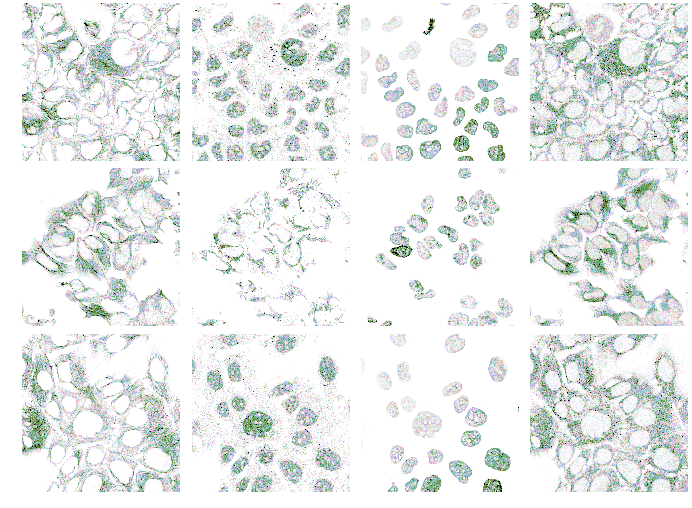

In [176]:
from skimage.exposure import equalize_adapthist, equalize_hist
width = 3.0
n_samples = 3
cmap = make_cmap(as_cmap = True)
imgs = train.get_images(train.any(27).sample(n_samples).index)
fig = plt.figure(figsize = (train.n_channels*width,n_samples*width))
gs = GridSpec(n_samples,test.n_channels, hspace = 0.05, wspace = 0.05)
for chan in range(train.n_channels):
    for sample in range(n_samples):
        band = imgs[sample,:,:,chan]
        band = np.digitize(band,bins)
        ax = plt.subplot(gs[sample,chan])
        ax.imshow(equalize_hist(band), cmap = cmap)
        ax.set_axis_off()

In [109]:
?GridSpec

## Data Exploration

### Class Populations

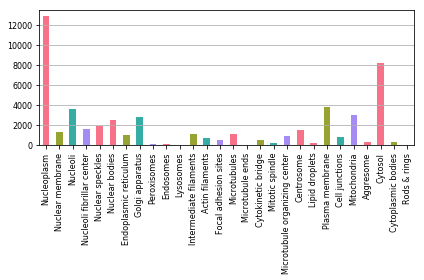

In [144]:
fig, ax = plt.subplots()
counts = train.labels.sum()
counts.plot.bar(ax = ax)
ax.yaxis.grid(True)
fig.tight_layout()
fig.savefig("plots/class_counts.pdf")

### Correlation Between Labels

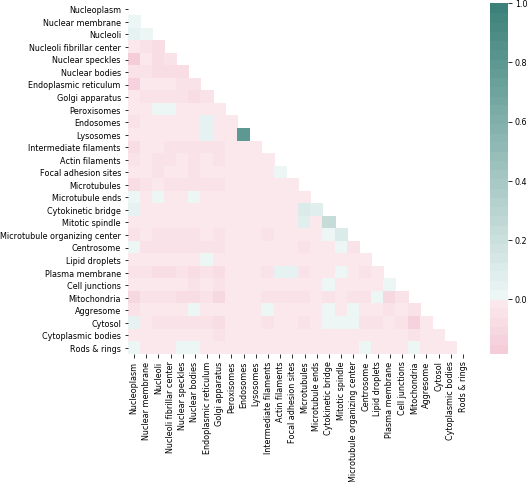

In [17]:
corr = train.labels.corr()
corr.columns = corr.index = train.classes

mask = np.zeros_like(corr.values)
mask[np.triu_indices_from(mask)] = True

fig, ax = plt.subplots(figsize = (8,7))
sns.heatmap(corr, ax = ax, mask = mask, center = 0,
            cmap = sns.diverging_palette(0,180,sep=1,n=64))

plt.tight_layout()
plt.savefig("plots/corr.pdf")

### Number of labels per example

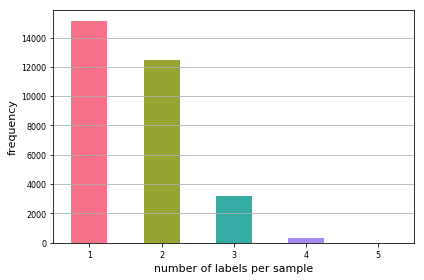

In [147]:
fig, ax = plt.subplots()
n_labels = train.labels.sum(axis = 1)
n_labels.value_counts().plot.bar(ax = ax, rot = 0)
ax.yaxis.grid()
ax.set_xlabel("number of labels per sample")
ax.set_ylabel("frequency")
fig.tight_layout()
fig.savefig("plots/label_count.pdf")

## Colormaps for Sample Images

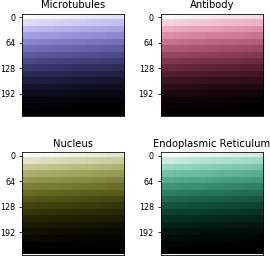

In [328]:
fig = plt.figure(figsize = (4,4))
gs = GridSpec(nrows = np.ceil(train.n_channels/2).astype(np.int32), ncols = 2,
              left = 0, bottom = 0, right = 1, top = 1)
for channel_ix in range(train.n_channels):
    ax = plt.subplot(gs[channel_ix])
    ax.imshow(np.arange(256).reshape(16,16) / 255, cmap = train.cmaps[channel_ix])
    ax.set_title(train.channels[channel_ix], fontsize = 10)
    ax.set_xticks([])
    ax.set_yticks(np.arange(4)/4*16)
    ax.set_yticklabels((np.arange(4)/4*256).astype(np.int32))

gs.tight_layout(fig)
fig.savefig("plots/colormaps.pdf", pad_inches = 0)

## Class Examples

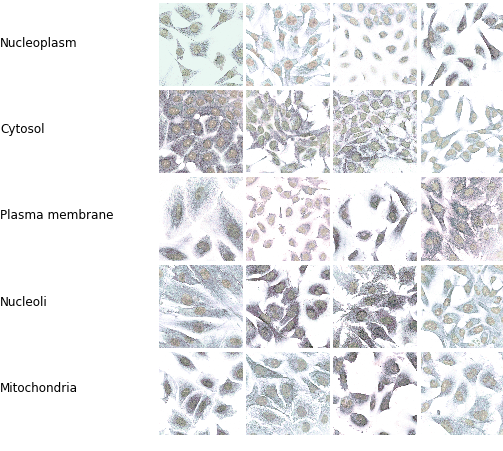

In [22]:
reload(pa)
train = pa.Train()

nrows = n_classes = 5
ncols = n_examples_per_class = 4
img_height = img_width = 1.2
label_width = 2.2

fig = plt.figure(figsize = (ncols*img_width + label_width,nrows*img_height))
gs = GridSpec(nrows,ncols, 
              hspace = 0.05, wspace = 0.05,
              left = label_width/(label_width + ncols*img_width), bottom = 0, top = 1, right = 1)

example_classes = train.labels.sum().sort_values(ascending=False).index[:n_classes]

for row_ix, class_ in enumerate(example_classes):
    ids = train.any(class_).sample(ncols).index
    imgs = train.get_images(ids)
    imgs = train.render_batch(imgs)
    fig.text(0,1-(row_ix+.5)/n_classes, s = class_, fontsize = 12)
 
    for sample_ix in range(ncols):
        img = imgs[sample_ix,:,:,:]
        ax = plt.subplot(gs[row_ix, sample_ix])
        ax.imshow(imgs[sample_ix,:,:,:])
        ax.set_axis_off()

        
fig.savefig("plots/exmples.pdf", dpi = 300)


## Input Pipeline

In [ ]:
reload(pa)
test = pa.Test()
train = pa.Train()

In [86]:
train_gen, val_gen = train.train_test_split(0.9)

## Neural Network

### Metrics

In [23]:
def f1_score(y_true, y_pred):
    """
    Calculate the f1 score of the predictions y_pred with respect to the
    ground truth y_true.
    
    Parameters:
    
        y_true : tensor, shape (n_examples,n_classes)
        
            The true class labels.
            
        y_pred : tensor, shape (n_examples,n_classes)
        
            Predicted classes, or predicted class probabilities. Class 
            probabilities will be rounded to 0 or 1 to compute the score.
            
    Returns:
    
        f1_score : variable

    Citation:
        
        Kaggle notebook of Michal Haltuf,
            https://www.kaggle.com/rejpalcz/best-loss-function-for-f1-score-metric
    """
    y_pred = K.round(y_pred)
    tp = K.sum(K.cast( y_true   * y_pred,   'float'), axis=0)
    tn = K.sum(K.cast((1-y_true)*(1-y_pred),'float'), axis=0)
    fp = K.sum(K.cast((1-y_true)* y_pred,   'float'), axis=0)
    fn = K.sum(K.cast( y_true   *(1-y_pred),'float'), axis=0)

    precision = tp / (tp + fp + K.epsilon())
    recall = tp / (tp + fn + K.epsilon())

    f1 = 2*precision*recall / (precision+recall+K.epsilon())
    f1 = tf.where(tf.is_nan(f1), K.zeros_like(f1), f1)
    return K.mean(f1)

def f1_loss(y_true, y_pred):
    """
    Calculate the f1 loss of the predictions y_pred with respect to the
    ground truth y_true.
    
    Parameters:
    
        y_true : tensor, shape (n_examples,n_classes)
        
            The true class labels.
            
        y_pred : tensor, shape (n_examples,n_classes)
        
            Predicted class probabilities.
            
    Returns:
    
        f1_loss : variable
        
    Citation:
        
        Kaggle notebook of Michal Haltuf,
        https://www.kaggle.com/rejpalcz/best-loss-function-for-f1-score-metric
    """
    tp = K.sum(K.cast(y_true*y_pred, 'float'), axis=0)
    tn = K.sum(K.cast((1-y_true)*(1-y_pred), 'float'), axis=0)
    fp = K.sum(K.cast((1-y_true)*y_pred, 'float'), axis=0)
    fn = K.sum(K.cast(y_true*(1-y_pred), 'float'), axis=0)

    p = tp / (tp + fp + K.epsilon())
    r = tp / (tp + fn + K.epsilon())

    f1 = 2*p*r / (p+r+K.epsilon())
    f1 = tf.where(tf.is_nan(f1), K.zeros_like(f1), f1)
    return 1 - K.mean(f1)

### Model

In [77]:
def make_baseline_model():
    inputs = Input(batch_shape = ((None,512,512,4)))

    #Resize:
    X = MaxPooling2D((4,4))(inputs)
    h = Conv2D(8,(3,3),activation="relu")(X)
    h = BatchNormalization(axis = -1)(h)
    
    h = MaxPooling2D((4,4))(h)
    h = Conv2D(16,(3,3),activation="relu")(h)
    h = BatchNormalization(axis = -1)(h)
    
    h = MaxPooling2D((4,4))(h)
    h = Conv2D(32,(3,3),activation="relu")(h)
    h = BatchNormalization(axis = -1)(h)

    h = Flatten()(h)
    h = Dense(400,activation="relu")(h)
    h = BatchNormalization(axis = -1)(h)    
    h = Dropout(0.1)(h)
    
    outputs = Dense(28,activation="sigmoid")(h)
    
    return Model(inputs,outputs)

In [78]:
def make_model():
    inputs = Input(batch_shape = ((None,512,512,4)))

    #Resize:
    X = MaxPooling2D((4,4))(inputs)

    h = Conv2D(8,(3,3),activation="relu")(X)
    h = BatchNormalization(axis = -1)(h)
    
    h = Conv2D(8,(3,3),activation="relu")(h)
    h = BatchNormalization(axis = -1)(h)

    h = Conv2D(16,(3,3),activation="relu")(h)
    h = BatchNormalization(axis = -1)(h)
    
    h = MaxPooling2D((2,2))(h)
    h = Dropout(0.25)(h)

    c1 = Conv2D(16,(3,3),padding="same",activation="relu")(h)
    c2 = Conv2D(16,(5,5),padding="same",activation="relu")(h)
    c3 = Conv2D(16,(7,7),padding="same",activation="relu")(h)
    c4 = Conv2D(16,(1,1),padding="same",activation="relu")(h)
    
    h = Concatenate()([c1,c2,c3,c4])
    h = BatchNormalization(axis=-1)(h)
    h = MaxPooling2D((2,2))(h)
    
    h = Conv2D(32,(3,3),activation="relu")(h)
    h = BatchNormalization(axis = -1)(h)
    h = MaxPooling2D((2,2))(h)
    h = Dropout(0.25)(h)

    h = Conv2D(64,(3,3),activation="relu")(h)
    h = BatchNormalization(axis = -1)(h)
    h = MaxPooling2D((2,2))(h)
    h = Dropout(0.25)(h)
    
    h = Conv2D(128,(3,3),activation="relu")(h)
    h = BatchNormalization(axis = -1)(h)
    h = MaxPooling2D((2,2))(h)
    h = Dropout(0.25)(h)
    
    h = Flatten()(h)
    h = Dropout(0.5)(h)
    
    h = Dense(28,activation="relu")(h)
    h = BatchNormalization(axis = -1)(h)
    h = Dropout(0.1)(h)
    
    outputs = Dense(28,activation="sigmoid")(h)
    
    return Model(inputs,outputs)

## Train the Baseline Model

In [83]:
# model = make_model()
model = make_baseline_model()
model.compile(loss = f1_loss, optimizer = Adam(1e-3))
model.summary()

##### FIT THE MODEL
N_EPOCHS = 1
BATCH_SIZE = 32

for epoch in range(N_EPOCHS):
    model.fit_generator(train_gen,validation_data = val_gen)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 512, 512, 4)       0         
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 128, 128, 4)       0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 126, 126, 8)       296       
_________________________________________________________________
batch_normalization_5 (Batch (None, 126, 126, 8)       32        
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 31, 31, 8)         0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 29, 29, 16)        1168      
_________________________________________________________________
batch_normalization_6 (Batch (None, 29, 29, 16)        64        
__________

KeyboardInterrupt: 

## Train the Final Model

In [ ]:
reload(pa)
test = pa.Test()
train = pa.Train()

model = make_baseline_model()
model.compile(loss = f1_loss, optimizer = Adam(1e-3))
model.summary()

##### FIT THE MODEL
N_EPOCHS = 1
BATCH_SIZE = 32

for epoch in range(N_EPOCHS):
    train_gen, val_gen = train.train_test_split(0.9, batch_size = BATCH_SIZE)
    model.fit_generator(train_gen,steps_per_epoch = 4)

## Make Predictions

## Submit Results to Kaggle

In [657]:
y = model.predict_generator(test.get_generator(BATCH_SIZE))

In [660]:
format_label = (lambda x:  " ".join([str(label) for label in x]))
predicted = pd.Series(train.mlb.inverse_transform(y.round())).apply(format_label)
padding = pd.Series(np.repeat("0",len(test.index) - len(predicted)))
predicted = predicted.append(padding)
predicted.index = test.index
submission = pd.DataFrame(predicted, columns = ["Predicted"])
submission_path = PATH["data"].joinpath("submission.csv")
submission.to_csv(str(submission_path))

In [661]:
submission

,Predicted
Id,
00008af0-bad0-11e8-b2b8-ac1f6b6435d0,0 2 3 4 5 15 27
0000a892-bacf-11e8-b2b8-ac1f6b6435d0,0 2 5 15 18 19 26 27
0006faa6-bac7-11e8-b2b7-ac1f6b6435d0,0 1 12 13 15 21 22
0008baca-bad7-11e8-b2b9-ac1f6b6435d0,0 15 16 17 18 25 26
000cce7e-bad4-11e8-b2b8-ac1f6b6435d0,0 7 15 18 26
00109f6a-bac8-11e8-b2b7-ac1f6b6435d0,0 1 2 3 4 5 15 26 27
001765de-bacd-11e8-b2b8-ac1f6b6435d0,0 1 2 4 5 12 15 27
0018641a-bac9-11e8-b2b8-ac1f6b6435d0,0 15 18 23 26
00200f22-bad7-11e8-b2b9-ac1f6b6435d0,0 5 7 15 16 18 19 22 26 27


In [662]:
submit_msg = "test-submit-message"
submit_cmd = [
    "kaggle", "competitions", "submit",
    "human-protein-atlas-image-classification", "-f", str(submission_path),
    "-m", submit_msg
]
subprocess.run(submit_cmd)


CompletedProcess(args=['kaggle', 'competitions', 'submit', 'human-protein-atlas-image-classification', '-f', '/Users/tim/dev/protein-atlas/data/submission.csv', '-m', 'test-submit-message'], returncode=0)